In [7]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [8]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'PlantVillage-Dataset/raw/color'
width=256
height=256
depth=3


In [9]:
def convert_image_to_array(image_dir):
  image = cv2.imread(image_dir)
  if image is not None :
    image = cv2.resize(image, default_image_size)   
    return img_to_array(image)
  else :
    return np.array([])

In [10]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


In [11]:
image_list, label_list = [], []

print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for plant_disease_folder in root_dir:
    plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
    for single_plant_disease_image in plant_disease_image_list:
        if single_plant_disease_image == ".DS_Store" :
            plant_disease_image_list.remove(single_plant_disease_image)

    for image in plant_disease_image_list[:10]:
        image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
            image_list.append(convert_image_to_array(image_directory))
            label_list.append(plant_disease_folder)
print("[INFO] Image loading completed")  

[INFO] Loading images ...
[INFO] Image loading completed


In [12]:
image_size = len(image_list)
print(image_size)

380


In [13]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [14]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [15]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [16]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [17]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

In [19]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [20]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/25
9/9 [==============================] - 34s 4s/step - loss: 0.1503 - accuracy: 0.9685 - val_loss: 0.1261 - val_accuracy: 0.9737
Epoch 2/25
9/9 [==============================] - 33s 4s/step - loss: 0.1235 - accuracy: 0.9716 - val_loss: 0.1720 - val_accuracy: 0.9713
Epoch 3/25
9/9 [==============================] - 34s 4s/step - loss: 0.1116 - accuracy: 0.9709 - val_loss: 0.2125 - val_accuracy: 0.9726
Epoch 4/25
9/9 [==============================] - 35s 4s/step - loss: 0.0951 - accuracy: 0.9726 - val_loss: 0.2340 - val_accuracy: 0.9643
Epoch 5/25
9/9 [==============================] - 40s 4s/step - loss: 0.0878 - accuracy: 0.9749 - val_loss: 0.2187 - val_accuracy: 0.9501
Epoch 6/25
9/9 [==============================] - 35s 4s/step - loss: 0.0819 - accuracy: 0.9750 - val_loss: 0.2410 - val_accuracy: 0.9737
Epoch 7/25
9/9 [==============================] - 34s 4s/step - loss: 0.0725 

{'val_loss': [0.1261068747231835, 0.1720320927469354, 0.21252467757777163, 0.23401086189244924, 0.2186902416379828, 0.24096143873114334, 0.2753047174529025, 0.3379671636380647, 0.31216356785673843, 0.3176016070340809, 0.39120108046029745, 0.3658155328349063, 0.3179921225497597, 0.3419184606326254, 0.3311161289089604, 0.40953279796399567, 0.3228006347229606, 0.31215670547987284, 0.3292026755056883, 0.3508642613887787, 0.30231965058728266, 0.28584548517277364, 0.3838544472267753, 0.31894806968538386, 0.334772400165859], 'val_accuracy': [0.9736841917037964, 0.9712603688240051, 0.9726454019546509, 0.9643352031707764, 0.950138509273529, 0.9736841917037964, 0.9612188935279846, 0.9473684430122375, 0.9619113802909851, 0.9549861550331116, 0.9473684430122375, 0.9490997791290283, 0.9529085755348206, 0.9515235424041748, 0.9574100375175476, 0.9473684430122375, 0.9584488272666931, 0.9574100375175476, 0.9608725309371948, 0.9522160887718201, 0.9594876170158386, 0.9529085755348206, 0.9477147459983826, 

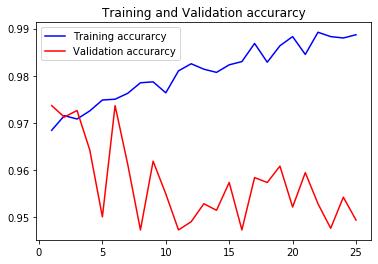

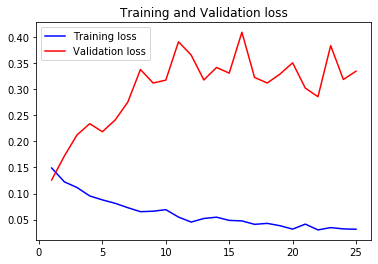

In [24]:
print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [25]:
print("[INFO] Calculating model accuracy")
predict = model.predict(x_test)
val = label_binarizer.inverse_transform(predict)[0]
print(val)

[INFO] Calculating model accuracy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


In [26]:
# _(# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [54]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

import tensorflow as tf

import cProfile

In [6]:
tf.executing_eagerly()

False